<a href="https://colab.research.google.com/github/gustavox0/Tecnicas_ML/blob/main/M6_AG1_Grupo17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contexto

IMDb es una de las mayores bases de datos de películas del mundo. A través de su sitio web es posible acceder a títulos, sinopsis, géneros, fechas de estreno y puntuaciones de millones de películas. En esta práctica, no se utilizará un dataset preexistente, sino que el alumno deberá **construir su propio dataset mediante web scraping**.

Se pide:

Con los datos recogidos, se entrenarán tres modelos supervisados de clasificación, todos ellos a partir del texto de la película: el título, la sinopsis o ambos.

  - Utilizar la página de exploración de géneros de IMDb: https://www.imdb.com/search/title/?explore=genres para extraer los siguientes datos para cada película:
    - Título
    - Sinopsis (texto resumen)
    - Fecha de estreno
    - Género principal
    - Puntuación media de IMDb.

Se deben obtener al menos 5 géneros distintos.

El número de películas por género queda a elección del alumno, pero se valorará reflexionar (y/o experimentar) sobre como influye el tamaño del dataset en la calidad del modelo.

# **Carga y exploración inicial del dataset**


**Creacion del DATASET**

Para la búsqueda y descarga de información, recurrimos a una estrategia de webscrapping. Para ello, utilizamos la API de OMDb.
Esta API se puede utilizar en una versión gratuita que permite la descarga de 1000 registros por día. No obstante, para no esperar en cada intento de descarga, compramos una clave privada para un mes.

In [88]:
#Cargar librerias
import requests
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import uniform
from tqdm import tqdm

In [ ]:
OMDB_API_KEY = "12545d08"  #API privada
GENRES = ['Action', 'Comedy', 'Drama', 'Horror', 'Sci-Fi']
MOVIES_PER_GENRE = 200
OUTPUT_FILE = "dataset_movies.csv"

# Estrategias combinadas de búsqueda
SEARCH_TERMS = ['a', 'the', 'man', 'woman', 'love', 'city', 'world',
               'day', 'night', 'life', 'death', 'home', 'family',
               'friend', 'time', 'last', 'new', 'old', 'young',
               'heart', 'sun', 'moon', 'star', 'king', 'queen']

YEARS = [str(year) for year in range(2020, 1920, -10)]  # De más reciente a más antiguo

def fetch_movie_details(imdb_id, retries=3):
    for attempt in range(retries):
        try:
            url = f"http://www.omdbapi.com/?apikey={OMDB_API_KEY}&i={imdb_id}&plot=short"
            response = requests.get(url)
            data = response.json()
            if data.get('Response') == 'True':
                return data
        except:
            sleep(uniform(1, 3))
    return None

def search_movies(params, target_genre, collected, seen_ids, max_movies):
    try:
        url = f"http://www.omdbapi.com/?apikey={OMDB_API_KEY}&type=movie"
        for key, value in params.items():
            url += f"&{key}={value}"

        res = requests.get(url)
        search_data = res.json()

        if search_data.get('Response') != 'True':
            return False

        for item in search_data.get('Search', []):
            imdb_id = item.get('imdbID')
            if not imdb_id or imdb_id in seen_ids:
                continue

            movie_data = fetch_movie_details(imdb_id)
            if not movie_data:
                continue

            genres = movie_data.get('Genre', '')
            if target_genre not in genres:
                continue

            collected.append({
                'Title': movie_data.get('Title'),
                'Plot': movie_data.get('Plot'),
                'Released': movie_data.get('Released'),
                'Genre': movie_data.get('Genre'),
                'Main_Genre': target_genre,
                'IMDb_Rating': movie_data.get('imdbRating'),
                'Year': movie_data.get('Year'),
                'Director': movie_data.get('Director'),
                'Actors': movie_data.get('Actors'),
                'IMDb_ID': imdb_id
            })

            seen_ids.add(imdb_id)
            print(f"[{target_genre}] {len(collected)}. {movie_data.get('Title')} ({movie_data.get('Year')})")

            if len(collected) >= max_movies:
                return True

        sleep(uniform(0.5, 1.5))
        return False

    except Exception as e:
        print(f"Error en búsqueda: {e}")
        sleep(2)
        return False

def get_movies_by_genre(target_genre, max_movies=200):
    collected = []
    seen_ids = set()

    # Estrategia 1: Búsqueda por términos comunes
    for term in tqdm(SEARCH_TERMS, desc=f"Buscando '{target_genre}' por términos"):
        if len(collected) >= max_movies:
            break

        for page in range(1, 21):  # Hasta 20 páginas por término
            if search_movies({'s': term, 'page': page}, target_genre, collected, seen_ids, max_movies):
                break

    # Estrategia 2: Búsqueda por años si no alcanzamos el máximo
    if len(collected) < max_movies:
        for year in tqdm(YEARS, desc=f"Buscando '{target_genre}' por años"):
            if len(collected) >= max_movies:
                break

            for page in range(1, 11):
                if search_movies({'y': year, 'page': page}, target_genre, collected, seen_ids, max_movies):
                    break

    # Estrategia 3: Búsqueda con combinación año+término
    if len(collected) < max_movies:
        for year in tqdm(YEARS, desc=f"Búsqueda combinada '{target_genre}'"):
            if len(collected) >= max_movies:
                break

            for term in ['a', 'the', 'movie']:
                for page in range(1, 6):
                    if search_movies({'s': term, 'y': year, 'page': page}, target_genre, collected, seen_ids, max_movies):
                        break

    return collected

# Ejecución principal
all_movies = []
for genre in GENRES:
    print(f"\n{'='*50}\nBuscando películas de: {genre}\n{'='*50}")
    movies = get_movies_by_genre(genre, MOVIES_PER_GENRE)
    all_movies.extend(movies)

    # Guardar resultados parciales
    pd.DataFrame(all_movies).to_csv(OUTPUT_FILE, index=False)
    print(f"\n>>> Progreso: {len(all_movies)} películas recolectadas")

# Resultados finales
df = pd.DataFrame(all_movies)
df.to_csv(OUTPUT_FILE, index=False)
print(f"\n{'='*50}\n{len(df)} películas guardadas en {OUTPUT_FILE}\n{'='*50}")
print("\nResumen por género:")
print(df['Main_Genre'].value_counts())


 Buscando películas del género: Action
[Action] 1. The Life Aquatic with Steve Zissou
[Action] 2. Bad Boys for Life
[Action] 3. Lara Croft: Tomb Raider - The Cradle of Life
[Action] 4. Proof of Life
[Action] 5. A Bittersweet Life
[Action] 6. Term Life
[Action] 7. Thor: Love and Thunder
[Action] 8. Love and Monsters
[Action] 9. From Russia with Love
[Action] 10. From Paris with Love
[Action] 11. Love Exposure
[Action] 12. I Love Trouble
[Action] 13. Love Hurts
[Action] 14. The Dark Knight
[Action] 15. The Dark Knight Rises
[Action] 16. Thor: The Dark World
[Action] 17. Transformers: Dark of the Moon
[Action] 18. X-Men: Dark Phoenix
[Action] 19. Terminator: Dark Fate
[Action] 20. The Dark Tower
[Action] 21. Batman: The Dark Knight Returns, Part 1
[Action] 22. Under Siege 2: Dark Territory
[Action] 23. Alone in the Dark
[Action] 24. Batman: The Dark Knight Returns, Part 2
[Action] 25. Hold the Dark
[Action] 26. Justice League Dark
[Action] 27. Justice League Dark: Apokolips War
[Action] 

La busqueda anterior genera el archivo csv "dataset_movies.csv". Dado el tiempo que toma realizar el "scrapeo" cada vez, a partir de acá guardamos el archivo generado y trabajemos con el para no realizar el webscrapping cada vez.

In [252]:
# Base generada mediante webscrapping
dataset0 = pd.read_csv("https://raw.githubusercontent.com/gustavox0/Tecnicas_ML/refs/heads/main/dataset_movies.csv")
dataset0.head()


,Title,Plot,Released,Genre,Main_Genre,IMDb_Rating,Year,Director,Actors,IMDb_ID
0,Iron Man,"After being held captive in an Afghan cave, bi...",02 May 2008,"Action, Adventure, Sci-Fi",Action,7.9,2008,Jon Favreau,"Robert Downey Jr., Gwyneth Paltrow, Terrence H...",tt0371746
1,Spider-Man: No Way Home,"With Spider-Man's identity now revealed, Peter...",17 Dec 2021,"Action, Adventure, Fantasy",Action,8.2,2021,Jon Watts,"Tom Holland, Zendaya, Benedict Cumberbatch",tt10872600
2,Iron Man 3,When Tony Stark's world is torn apart by a for...,03 May 2013,"Action, Adventure, Sci-Fi",Action,7.1,2013,Shane Black,"Robert Downey Jr., Guy Pearce, Gwyneth Paltrow",tt1300854
3,Spider-Man,After being bitten by a genetically-modified s...,03 May 2002,"Action, Adventure, Sci-Fi",Action,7.4,2002,Sam Raimi,"Tobey Maguire, Kirsten Dunst, Willem Dafoe",tt0145487
4,Iron Man 2,With the world now aware of his identity as Ir...,07 May 2010,"Action, Sci-Fi",Action,6.9,2010,Jon Favreau,"Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",tt1228705


Como podemos observar, descargamos las variables

  - Title (Titulo)
  - Plot (Sinopsis)
  - Released (Fecha de Estreno)
  - Genre (los generos asociados)
  - Main_Genre (Género principal)
  - IMDb_Rating	(Puntuación IMDb)
  - Year	(Año)
  - Director
  - Actors
  - IMDb_ID

Para la realización del ejercicio, seleccionamos un subdataset con las variables necesarias. Es decir, Titulo, Sinopsis, Fecha de Estreno, Género y Puntuación IMDb.

In [254]:
#Seleccion de variables de dataset y cambio de nombres
dataset1=dataset0[['Title','Plot','Released','Main_Genre','IMDb_Rating','Year']]
dataset1.columns=['Título','Sinopsis','Fecha de estreno','Género principal','Puntuación IMDb','Año']
dataset1.head()
#Mantenemos Year para, en caso de tener valores nulos en Fecha de Estreno, imputar el valor en año.

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
0,Iron Man,"After being held captive in an Afghan cave, bi...",02 May 2008,Action,7.9,2008
1,Spider-Man: No Way Home,"With Spider-Man's identity now revealed, Peter...",17 Dec 2021,Action,8.2,2021
2,Iron Man 3,When Tony Stark's world is torn apart by a for...,03 May 2013,Action,7.1,2013
3,Spider-Man,After being bitten by a genetically-modified s...,03 May 2002,Action,7.4,2002
4,Iron Man 2,With the world now aware of his identity as Ir...,07 May 2010,Action,6.9,2010


In [255]:
#Resumen de la base
print(dataset1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Título            1000 non-null   object 
 1   Sinopsis          1000 non-null   object 
 2   Fecha de estreno  987 non-null    object 
 3   Género principal  1000 non-null   object 
 4   Puntuación IMDb   996 non-null    float64
 5   Año               1000 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB
None


Como puede observarse, el dataset contiene la información de 1000 películas y los atributos Título, Sinópsis, Fecha de estreno, Género de película y
Puntuación IMDb.

  - Valores duplicados

In [256]:
#Mostrar registros duplicados por Título
conteo=dataset1['Título'].value_counts()
duplicados=conteo[conteo>1]
dataset1[dataset1['Título'].isin(duplicados.index)]

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
0,Iron Man,"After being held captive in an Afghan cave, bi...",02 May 2008,Action,7.9,2008
2,Iron Man 3,When Tony Stark's world is torn apart by a for...,03 May 2013,Action,7.1,2013
3,Spider-Man,After being bitten by a genetically-modified s...,03 May 2002,Action,7.4,2002
4,Iron Man 2,With the world now aware of his identity as Ir...,07 May 2010,Action,6.9,2010
5,Man of Steel,An alien child is evacuated from his dying wor...,14 Jun 2013,Action,7.1,2013
...,...,...,...,...,...,...
929,Death Machine,After a mad genius inventor of killer robots a...,04 Feb 1994,Sci-Fi,5.6,1994
934,The Man Who Could Cheat Death,A centenarian artist and scientist in 1890 Par...,30 Nov 1959,Sci-Fi,6.3,1959
953,The Time Machine,"Hoping to alter the events of the past, a 19th...",08 Mar 2002,Sci-Fi,6.0,2002
955,The Time Machine,A man's vision for a utopian society is disill...,25 Aug 1960,Sci-Fi,7.5,1960


Como puede observarse, el dataset contiene peliculas duplicadas. Por lo cual procedemos a eliminar aquellos registros que aparecen en más de una ocasión

In [257]:
dataset1.drop_duplicates(subset='Título', keep='first', inplace=True)
dataset1.reset_index(drop=True, inplace=True)
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Título            752 non-null    object 
 1   Sinopsis          752 non-null    object 
 2   Fecha de estreno  744 non-null    object 
 3   Género principal  752 non-null    object 
 4   Puntuación IMDb   750 non-null    float64
 5   Año               752 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 35.4+ KB


/tmp/ipython-input-257-2207591458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1.drop_duplicates(subset='Título', keep='first', inplace=True)


In [258]:
#duplicados
conteo2=dataset1['Título'].value_counts()
conteo2[conteo2>1].value_counts()

,count
count,


Podemos observar que el dataset ya no contiene valores duplicados. Sin embargo, se eliminaron 248 registros repetidos.

  * Valores nulos

In [259]:
#Valores nulos
print(dataset1.isna().sum())

Título              0
Sinopsis            0
Fecha de estreno    8
Género principal    0
Puntuación IMDb     2
Año                 0
dtype: int64


Como puede observarse, el dataset contiene valores nulos en las variables Fecha de estreno y Puntuación. Dado que no es posible implementar los modelos en las variables target, vamos a analizar dichas observaciones para darles tratamiento
e imputar los valores faltantes.

In [260]:
#Valores nulos de fecha de estreno
dataset1[dataset1['Fecha de estreno'].isna()]

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
255,The Man in the White Suit,An altruistic chemist invents a fabric which r...,NaN,Comedy,7.2,1951
280,How to Make Love to a Woman,When Andy hears his girlfriend Lauren sigh aft...,NaN,Comedy,4.1,2010
498,The Werewolf Versus the Vampire Woman,Elvira and her friend Genevieve travel through...,NaN,Horror,5.3,1971
553,The Day Time Ended,Aliens visit the solar-powered house of a midd...,NaN,Horror,3.5,1979
635,Island of Death,A couple of perverted and maniac killers get l...,NaN,Horror,5.1,1976
654,The Wild World of Batwoman,Batwoman and her bevy of Batmaidens fight evil...,NaN,Sci-Fi,1.8,1966
703,My Friend Frankenstein,The film takes on the struggle of Timur Frank ...,NaN,Sci-Fi,5.7,1975
750,Outpost: Black Sun,"The year is 1945, the closing stages of WW2, a...",NaN,Sci-Fi,4.9,2012


Observamos que la variable "Fecha de estreno" tiene valores faltantes pero el año se encuentra en la variable "Año". Vamos a imputar dicho valor a Fecha de estreno por medio de los índices correspondientes. Nótese sin embargo que el valor en "Año" es un entero, para mantener el formato en Fecha de estreno, vamos a imputar el 1 de enero para cada año (1 Jan XXXX)

In [261]:
#modificar valores por indice
dataset1.at[255, 'Fecha de estreno'] = '1 Jan 1951'
dataset1.at[280, 'Fecha de estreno'] = '1 Jan 2010'
dataset1.at[498, 'Fecha de estreno'] = '1 Jan 1971'
dataset1.at[553, 'Fecha de estreno'] = '1 Jan 1979'
dataset1.at[635, 'Fecha de estreno'] = '1 Jan 1976'
dataset1.at[654, 'Fecha de estreno'] = '1 Jan 1966'
dataset1.at[703, 'Fecha de estreno'] = '1 Jan 1975'
dataset1.at[750, 'Fecha de estreno'] = '1 Jan 2012'


In [262]:
dataset1.iloc[[255,280,498,553,635,654,703,750]]

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
255,The Man in the White Suit,An altruistic chemist invents a fabric which r...,1 Jan 1951,Comedy,7.2,1951
280,How to Make Love to a Woman,When Andy hears his girlfriend Lauren sigh aft...,1 Jan 2010,Comedy,4.1,2010
498,The Werewolf Versus the Vampire Woman,Elvira and her friend Genevieve travel through...,1 Jan 1971,Horror,5.3,1971
553,The Day Time Ended,Aliens visit the solar-powered house of a midd...,1 Jan 1979,Horror,3.5,1979
635,Island of Death,A couple of perverted and maniac killers get l...,1 Jan 1976,Horror,5.1,1976
654,The Wild World of Batwoman,Batwoman and her bevy of Batmaidens fight evil...,1 Jan 1966,Sci-Fi,1.8,1966
703,My Friend Frankenstein,The film takes on the struggle of Timur Frank ...,1 Jan 1975,Sci-Fi,5.7,1975
750,Outpost: Black Sun,"The year is 1945, the closing stages of WW2, a...",1 Jan 2012,Sci-Fi,4.9,2012


Como podemos observar, la variable Fecha de estreno ya no contiene valores nulos.

In [263]:
#valores nulos de puntuacion imdb
dataset1[dataset1['Puntuación IMDb'].isna()]

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
279,"Where the Devil Can't Go, He Sends a Woman",Poland in the 80's was a country ruled by cris...,14 Oct 2022,Comedy,NaN,2022
282,"Where the Devil Can't Go, He Sends a Woman 2","The story of Polish fortunes, how were state-o...",20 Jan 2023,Comedy,NaN,2023


Observamos que las películas "Where the Devil Can't Go, He Sends a Woman" y "Where the Devil Can't Go, He Sends a Woman 2" no tienen la puntuación. En la liga https://www.imdb.com/es-es/title/tt15019036/ la pelicula "Where the Devil Can't Go, He Sends a Woman" tiene puntuación de 5.7, mientras que en liga https://www.imdb.com/es-es/title/tt20100884/, la versión 2 tiene una puntuación de 6.0. Procedemos a imputar estos valores

In [264]:
# Cambiar la puntuación de la fila 61 (índice 61) en 'puntuacion_IMDb' a 3.6 y fecha de estreno
dataset1.at[279, 'Puntuación IMDb'] = 5.7
dataset1.at[282, 'Puntuación IMDb'] = 6.0
dataset1.iloc[[279, 282]]

,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb,Año
279,"Where the Devil Can't Go, He Sends a Woman",Poland in the 80's was a country ruled by cris...,14 Oct 2022,Comedy,5.7,2022
282,"Where the Devil Can't Go, He Sends a Woman 2","The story of Polish fortunes, how were state-o...",20 Jan 2023,Comedy,6.0,2023


Como podemos observar, ya no tenemos valores faltantes en el dataset como se muestra a contiunación.

In [265]:
#Valores nulos
print(dataset1.isna().sum())

Título              0
Sinopsis            0
Fecha de estreno    0
Género principal    0
Puntuación IMDb     0
Año                 0
dtype: int64


  * Balance del dataset

In [266]:
# Películas por género
print(round(dataset1['Género principal'].value_counts(normalize=True) * 100,2))

Género principal
Action    25.80
Comedy    23.14
Horror    21.68
Drama     15.56
Sci-Fi    13.83
Name: proportion, dtype: float64


El dataset se encuentra desbalanceado. El género con menos películas es el Sci-Fi (5.18%) y el que tiene más información es el de Drama (34.45%).  

Esto debe tomarse en consideración al momento de particionar el dataset para no generar sesgos en el entrenamiento del modelo

### Dataset definitivo
 Una vez revisados los duplicados, valores faltantes y el balance, el dataset definitivo para comenzar a trabajar es el siguiente:

In [267]:
dataset=dataset1.copy()
#seleccionar sub de variables en dataset
dataset=dataset[['Título','Sinopsis','Fecha de estreno','Género principal','Puntuación IMDb']]
dataset.head()


,Título,Sinopsis,Fecha de estreno,Género principal,Puntuación IMDb
0,Iron Man,"After being held captive in an Afghan cave, bi...",02 May 2008,Action,7.9
1,Spider-Man: No Way Home,"With Spider-Man's identity now revealed, Peter...",17 Dec 2021,Action,8.2
2,Iron Man 3,When Tony Stark's world is torn apart by a for...,03 May 2013,Action,7.1
3,Spider-Man,After being bitten by a genetically-modified s...,03 May 2002,Action,7.4
4,Iron Man 2,With the world now aware of his identity as Ir...,07 May 2010,Action,6.9


# **Preprocesamiento**

## Limpieza del texto

Para preparar el dataset, vamos a realizar las siguientes tareas:

  - Pasar todo el texto a minúsculas para evitar duplicado de palabras
  - Eliminar símbolos como números, acentos, signos de puntuación, emojis o cualquier otro caracter especial.
  - Eliminar stopwords (palabras que no aportan mucho significado y operan más como preposiciones como "the", "is", "at", "which", "on" y "and".
  - Lematización: para reducir la palabra a su raíz y mejorar la capacidad de unificar palabras (precisión).

Antes de proceder, realizamos una copia del dataset para comenzar a limpiar el texto y preparar los datos.

In [268]:
Base=dataset.copy()

**Pasar texto a minúsculas**

In [269]:
import nltk
nltk.download('stopwords')

Base['Título'] = Base['Título'].str.lower()
Base['Sinopsis'] = dataset['Sinopsis'].str.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Eliminar símbolos**

In [270]:
import re
Base['Título'] = Base['Título'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
Base['Sinopsis'] = Base['Sinopsis'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

**Eliminar stopwords**

In [271]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

Base['Título'] = Base['Título'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
Base['Sinopsis'] = Base['Sinopsis'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

**Lematizacion**

In [272]:
import spacy
nlp = spacy.load("en_core_web_sm")

Base['Sinopsis'] = Base['Sinopsis'].apply(
    lambda text: ' '.join([token.lemma_ for token in nlp(text)]))
Base['Título'] = Base['Título'].apply(
    lambda text: ' '.join([token.lemma_ for token in nlp(str(text))]))

## Aplicar vectorización con TF-IDF, CountVectorizer o embeddings.

La vectorización hace referencia a la conversión del texto en vectores que los algoritmos que vamos a implementar puedan entender. Debemos vectorizar las variables que vamos a utilizar como predictoras, es decir, *Título* y *Sinopsis* y una combinación de ambas. Por lo anterior, vamos a crear una nueva variable que concatene Titulo+Sinopsis para, posteriormente, utilizar TD-IDF para vectorizar la información.

  - Creación de nueva variable

In [273]:
#concatenar Titulo+Sinopsis
Base['Txt_Combinado'] = Base['Título'] + ' ' + Base['Sinopsis']

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Aplicarvectorizacion con TF-IDF
vectorizer = TfidfVectorizer()
X_titulo = vectorizer.fit_transform(Base['Título'])
X_sinopsis = vectorizer.fit_transform(Base['Sinopsis'])
X_combinado = vectorizer.fit_transform(Base['Txt_Combinado'])

## Creación de variables objetivo

Las variables objetivo son:

  - Género (multiclase)
  - Fecha de estreno (agrupar por décadas, por ejemplo: 1990,2000,2020,)
  - Puntuación (variable continua)

**Género (multiclase)**

Codificamos la variable género para usar como target

In [275]:
#Crear la variable Gener (multiclase)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Base['Género'] = le.fit_transform(Base['Género principal'])

# Tabla de códigos transformados
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Action': np.int64(0),
 'Comedy': np.int64(1),
 'Drama': np.int64(2),
 'Horror': np.int64(3),
 'Sci-Fi': np.int64(4)}

Como se observa, la variable *Género* ya se ha codificado en una variable multiclase dentro del dataset. La variable codificada toma valores de 0 a 4 donde Action:0, Comedy:1, Drama:2, Horror:3 y Sci-Fi:4.

**Fecha de estreno**

 (agrupar por décadas, por ejemplo: 1990s, 2000s, 2010s, 2020s...)

In [276]:
Base['Fecha de estreno'] = pd.to_datetime(Base['Fecha de estreno'],format='mixed', errors='coerce') #cambio el tipo a datetime
Base['Decada'] = Base['Fecha de estreno'].dt.year // 10 * 10

**Puntuación (variable continua)**

In [277]:
Base['Puntuacion'] = pd.to_numeric(Base['Puntuación IMDb'])#asegurar que es float y no texto

A continuación definimos las variables target

In [278]:
y_genero=Base['Género']
y_decada=Base['Decada']
y_puntuacion=Base['Puntuacion']

# **Modelado**

 - Entrenar tres modelos de clasificación, uno por cada variable objetivo y probar al menos dos algoritmos por modelo.

Para esta tarea, recurrimos a los modelos de **clasificación** KNN y Random Forest  para  predecir el Género y la década y a los modelos de **regresión** árbol de decisión y Naive Bayes para predecir la puntuación.

Primero vamos a dividir el dataset en entrenamiento y test. Posteriormente, comparamos las métricas de cada modelo (accuracy, F1-score, matriz de confusión...) y finalmente comentamos sobre la elección del modelo.

In [192]:
print(round(y_genero.value_counts(normalize=True),4)*100)

Género
0    25.80
1    23.14
3    21.68
2    15.56
4    13.83
Name: proportion, dtype: float64


In [279]:
print(round(y_decada.value_counts(normalize=True),4)*100)

Decada
2010    29.26
2000    15.82
2020    15.16
1990    10.24
1980     9.04
1970     6.38
1960     5.45
1950     3.72
1940     2.66
1930     1.60
1920     0.40
1910     0.13
1890     0.13
Name: proportion, dtype: float64


Importante: El dataset no se encuentra balanceado para Género (Accion tiene 25.8% de registros y Sci-Fi solo 13,83%). La variable Decada tampoco se encuentra balanceada, sobre todo para peliculas anteriores a 1970. Para mejorar la capacidad de los modelos, vamos a agrupar todas las peliculas previas a 1970 en esta década en una nueva categoría. Esta identificará a las películas estrenadas en la decada de 1970 o antes. Igualmente, vamos a agrupar las peliculas de 80-90 en la decada de 1990, lo que identificará peliculas estrenadas en las décadas 1980-1990. Por tanto, tendremos las siguientes categorías:

  - 1970
  - 1990
  - 2000
  - 2010
  - 2020

In [280]:
#Pelis de 1970 y antes
Base.loc[Base['Decada'] < 1970, 'Decada'] = 1970
#Pelis 80-90
Base.loc[(Base['Decada'] >= 1980) & (Base['Decada'] <= 1999), 'Decada'] = 1990
#
y_decada=Base['Decada']

print(round(y_decada.value_counts(normalize=True),4)*100)

Decada
2010    29.26
1970    20.48
1990    19.28
2000    15.82
2020    15.16
Name: proportion, dtype: float64


Partición del dataset

Debemos realizar particiones para cada combinación que vamos a utilizar para los modelos. Vamos a predecir cada variable objetivo con la información del Sinopsis y con la combinación de Titulo y sinópsis (para ver la aportación de Título). Por tanto, requerimos hacer dos particiones de los datos para cada variable Target, uno solo con sinopsis como predictora y otro con la combinación de ambas como predictora. En total debemos crear 6 particiones.

Vamos a utilizar el 70% de los datos para entrenar y 30% para probar.

In [281]:
from sklearn.model_selection import train_test_split

#-----------------------Partición para predecir Género------------------------
# Escenario 1: X_sinopsis → Género
X_train_sinopsis_gen, X_test_sinopsis_gen, y_train_gen, y_test_gen = train_test_split(
    X_sinopsis, y_genero, test_size=0.3, random_state=42,stratify=y_genero)

# Escenario 2: X_ambos → Género
X_train_comb_gen, X_test_comb_gen, _, _ = train_test_split(
    X_combinado, y_genero, test_size=0.3, random_state=42, stratify=y_genero)

#----------------------Partición para predecir Decada------------------------
# Escenario 1: X_sinopsis → Década
X_train_sinopsis_dec, X_test_sinopsis_dec, y_train_dec, y_test_dec = train_test_split(
    X_sinopsis, y_decada, test_size=0.3, random_state=42,stratify=y_decada)

# Escenario 2: X_ambos → Década
X_train_comb_dec, X_test_comb_dec, _, _ = train_test_split(
    X_combinado, y_decada, test_size=0.3, random_state=42,stratify=y_decada)

#----------------------Partición para predecir Puntuación------------------------
# Escenario 1: X_sinopsis → Puntuación
X_train_sinopsis_punt, X_test_sinopsis_punt, y_train_punt, y_test_punt = train_test_split(
    X_sinopsis, y_puntuacion, test_size=0.3, random_state=42)

# Escenario 3: X_ambos → Puntuación
X_train_comb_punt, X_test_comb_punt, _, _ = train_test_split(
    X_combinado, y_puntuacion, test_size=0.3, random_state=42)

## Modelo de clasificación KNN

### Sinopsis

#### Genero

In [282]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Elección del número de vecinos. Para ello, vamos a recurrir a una búsqueda grid con GridSearch

In [283]:
#Determinar número de vecinos optimo
accuracy_val=[]
weights="uniform"
metric="cosine"
#Entrenamos el modelo para valores de impares de k entre 1 y 20.
for k in list(range(1, 100, 2)):
  #entrenar modelo
  knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
  knn_model.fit(X_train_sinopsis_gen, y_train_gen)
  #predecir valores
  y_pred = knn_model.predict(X_test_sinopsis_gen)
  #calcular accuracy
  accuracy = accuracy_score(y_test_gen, y_pred)
  accuracy_val.append(accuracy)
  print(f"Accuracy para k={k}: {round(accuracy*100,2)}")

Accuracy para k=1: 39.82
Accuracy para k=3: 40.27
Accuracy para k=5: 40.27
Accuracy para k=7: 45.58
Accuracy para k=9: 44.25
Accuracy para k=11: 44.69
Accuracy para k=13: 47.79
Accuracy para k=15: 46.46
Accuracy para k=17: 46.02
Accuracy para k=19: 47.35
Accuracy para k=21: 48.67
Accuracy para k=23: 48.23
Accuracy para k=25: 48.23
Accuracy para k=27: 47.35
Accuracy para k=29: 45.58
Accuracy para k=31: 48.23
Accuracy para k=33: 50.44
Accuracy para k=35: 47.79
Accuracy para k=37: 50.0
Accuracy para k=39: 51.33
Accuracy para k=41: 50.0
Accuracy para k=43: 50.44
Accuracy para k=45: 52.21
Accuracy para k=47: 50.88
Accuracy para k=49: 49.56
Accuracy para k=51: 51.33
Accuracy para k=53: 50.44
Accuracy para k=55: 50.0
Accuracy para k=57: 50.44
Accuracy para k=59: 49.12
Accuracy para k=61: 49.56
Accuracy para k=63: 50.0
Accuracy para k=65: 50.88
Accuracy para k=67: 50.44
Accuracy para k=69: 49.56
Accuracy para k=71: 50.44
Accuracy para k=73: 47.79
Accuracy para k=75: 50.44
Accuracy para k=77: 5

Como se observa, la mayor precisión (52,21) del modelo es para 45 vecinos.

In [284]:
#Entrenanamiento del modelo.
knn_model = KNeighborsClassifier(n_neighbors=45, weights="uniform", metric="cosine")
knn_model.fit(X_train_sinopsis_gen, y_train_gen)
#Prediccion
y_pred = knn_model.predict(X_test_sinopsis_gen)
cm_gen_sinopsis=confusion_matrix(y_test_gen, y_pred)

ags=cm_gen_sinopsis[0,0]
bgs=cm_gen_sinopsis[0,1]
cgs=cm_gen_sinopsis[1,0]
dgs=cm_gen_sinopsis[1,1]

TP_gen_sin=dgs/(cgs+dgs)
FP_gen_sin=bgs/(ags+bgs)
TN_gen_sin=ags/(ags+bgs)
FN_gen_sin=cgs/(cgs+dgs)

accuracy_gen_sin = (ags+dgs)/(ags+bgs+cgs+dgs)
error_gen_sin = 1-accuracy_gen_sin
precision_gen_sin=TP_gen_sin/(TP_gen_sin+FP_gen_sin)
recall_gen_sin=TP_gen_sin/(TP_gen_sin+FN_gen_sin)
F_gen_sin=2*(precision_gen_sin*recall_gen_sin)/(precision_gen_sin+recall_gen_sin)

print("Accuracy_gen_sin: ", round(accuracy_gen_sin,4))
print("Error_gen_sin: ", round(error_gen_sin,4))
print("Precision_gen_sin: ", round(precision_gen_sin,4))
print("Recall_gen_sin: ", round(recall_gen_sin,4))
print("F-meassure_gen_sin: ", round(F_gen_sin,4))

Accuracy_gen_sin:  0.7895
Error_gen_sin:  0.2105
Precision_gen_sin:  0.7907
Recall_gen_sin:  0.7872
F-meassure_gen_sin:  0.789


#### Decada

In [285]:
#Determinar número de vecinos optimo
accuracy_val=[]
#Entrenamos el modelo para valores de impares de k entre 1 y 100.
for k in list(range(1, 100, 2)):
  #entrenar modelo
  knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
  knn_model.fit(X_train_sinopsis_dec, y_train_dec)
  #predecir valores
  y_pred = knn_model.predict(X_test_sinopsis_dec)
  #calcular accuracy
  accuracy = accuracy_score(y_test_dec, y_pred)
  accuracy_val.append(accuracy)
  print(f"Accuracy para k={k}: {round(accuracy*100,2)}")

Accuracy para k=1: 25.66
Accuracy para k=3: 25.22
Accuracy para k=5: 26.55
Accuracy para k=7: 22.12
Accuracy para k=9: 21.24
Accuracy para k=11: 23.89
Accuracy para k=13: 24.34
Accuracy para k=15: 23.45
Accuracy para k=17: 24.78
Accuracy para k=19: 26.99
Accuracy para k=21: 28.32
Accuracy para k=23: 28.76
Accuracy para k=25: 29.65
Accuracy para k=27: 28.76
Accuracy para k=29: 27.88
Accuracy para k=31: 28.76
Accuracy para k=33: 28.76
Accuracy para k=35: 27.43
Accuracy para k=37: 27.88
Accuracy para k=39: 28.76
Accuracy para k=41: 28.32
Accuracy para k=43: 27.88
Accuracy para k=45: 27.43
Accuracy para k=47: 27.88
Accuracy para k=49: 27.88
Accuracy para k=51: 30.09
Accuracy para k=53: 30.09
Accuracy para k=55: 28.32
Accuracy para k=57: 29.65
Accuracy para k=59: 29.2
Accuracy para k=61: 30.97
Accuracy para k=63: 30.97
Accuracy para k=65: 30.53
Accuracy para k=67: 29.65
Accuracy para k=69: 29.2
Accuracy para k=71: 30.53
Accuracy para k=73: 29.65
Accuracy para k=75: 30.09
Accuracy para k=77:

Como puede observarse, la mayor precisión (30,97) es con un número de vecinos igual a 61. Procedemos a entrenar el modelo con este número de vecinos.

In [286]:
#Entrenanamiento del modelo.
knn_model = KNeighborsClassifier(n_neighbors=61, weights="uniform", metric="cosine")
knn_model.fit(X_train_sinopsis_dec, y_train_dec)
#Prediccion
y_pred = knn_model.predict(X_test_sinopsis_dec)
cm_dec_sinopsis=confusion_matrix(y_test_dec, y_pred)

ads=cm_dec_sinopsis[0,0]
bds=cm_dec_sinopsis[0,1]
cds=cm_dec_sinopsis[1,0]
dds=cm_dec_sinopsis[1,1]

TP_dec_sin=dds/(cds+dds)
FP_dec_sin=bds/(ads+bds)
TN_dec_sin=ads/(ads+bds)
FN_dec_sin=cds/(cds+dds)

accuracy_dec_sin = (ads+dds)/(ads+bds+cds+dds)
error_dec_sin = 1-accuracy_dec_sin
precision_dec_sin=TP_dec_sin/(TP_dec_sin+FP_dec_sin)
recall_dec_sin=TP_dec_sin/(TP_dec_sin+FN_dec_sin)
F_dec_sin=2*(precision_dec_sin*recall_dec_sin)/(precision_dec_sin+recall_dec_sin)

print("Accuracy_dec_sin: ", round(accuracy_dec_sin,4))
print("Error_dec_sin: ", round(error_dec_sin,4))
print("Precision_dec_sin: ", round(precision_dec_sin,4))
print("Recall_dec_sin: ", round(recall_dec_sin,4))
print("F-meassure_dec_sin: ", round(F_dec_sin,4))

Accuracy_dec_sin:  0.56
Error_dec_sin:  0.44
Precision_dec_sin:  0.5161
Recall_dec_sin:  0.3333
F-meassure_dec_sin:  0.4051


### Sinopsis+Titulo

#### Genero

In [287]:
#Determinar número de vecinos optimo
accuracy_val=[]
weights="uniform"
metric="cosine"
#Entrenamos el modelo para valores de impares de k entre 1 y 20.
for k in list(range(1, 100, 2)):
  #entrenar modelo
  knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
  knn_model.fit(X_train_comb_gen, y_train_gen)
  #predecir valores
  y_pred = knn_model.predict(X_test_comb_gen)
  #calcular accuracy
  accuracy = accuracy_score(y_test_gen, y_pred)
  accuracy_val.append(accuracy)
  print(f"Accuracy para k={k}: {round(accuracy*100,2)}")

Accuracy para k=1: 43.81
Accuracy para k=3: 48.23
Accuracy para k=5: 50.44
Accuracy para k=7: 53.1
Accuracy para k=9: 53.98
Accuracy para k=11: 55.75
Accuracy para k=13: 57.52
Accuracy para k=15: 61.06
Accuracy para k=17: 60.18
Accuracy para k=19: 58.85
Accuracy para k=21: 62.83
Accuracy para k=23: 61.5
Accuracy para k=25: 62.39
Accuracy para k=27: 61.5
Accuracy para k=29: 59.73
Accuracy para k=31: 59.73
Accuracy para k=33: 58.85
Accuracy para k=35: 59.29
Accuracy para k=37: 59.29
Accuracy para k=39: 58.41
Accuracy para k=41: 59.29
Accuracy para k=43: 61.06
Accuracy para k=45: 60.18
Accuracy para k=47: 60.62
Accuracy para k=49: 61.5
Accuracy para k=51: 61.95
Accuracy para k=53: 61.5
Accuracy para k=55: 60.62
Accuracy para k=57: 60.18
Accuracy para k=59: 61.06
Accuracy para k=61: 58.85
Accuracy para k=63: 59.73
Accuracy para k=65: 61.06
Accuracy para k=67: 61.06
Accuracy para k=69: 61.5
Accuracy para k=71: 62.83
Accuracy para k=73: 59.73
Accuracy para k=75: 60.62
Accuracy para k=77: 61.

Observamos que el mayor rendimiento (62,83%) es con 21 vecinos.

In [288]:
#Entrenanamiento del modelo.
knn_model = KNeighborsClassifier(n_neighbors=21, weights="uniform", metric="cosine")
knn_model.fit(X_train_comb_gen, y_train_gen)
#Prediccion
y_pred = knn_model.predict(X_test_comb_gen)
cm_gen_comb=confusion_matrix(y_test_gen, y_pred)

agc=cm_gen_comb[0,0]
bgc=cm_gen_comb[0,1]
cgc=cm_gen_comb[1,0]
dgc=cm_gen_comb[1,1]

TP_gen_c=dgc/(cgc+dgc)
FP_gen_c=bgc/(agc+bgc)
TN_gen_c=agc/(agc+bgc)
FN_gen_c=cgc/(cgc+dgc)

accuracy_gen_c = (agc+dgc)/(agc+bgc+cgc+dgc)
error_gen_c = 1-accuracy_gen_c
precision_gen_c=TP_gen_c/(TP_gen_c+FP_gen_c)
recall_gen_c=TP_gen_c/(TP_gen_c+FN_gen_c)
F_gen_c=2*(precision_gen_c*recall_gen_c)/(precision_gen_c+recall_gen_c)

print("Accuracy_gen_c: ", round(accuracy_gen_c,4))
print("Error_gen_c: ", round(error_gen_c,4))
print("Precision_gen_c: ", round(precision_gen_c,4))
print("Recall_gen_c: ", round(recall_gen_c,4))
print("F-meassure_gen_c: ", round(F_gen_c,4))

Accuracy_gen_c:  0.85
Error_gen_c:  0.15
Precision_gen_c:  0.8513
Recall_gen_c:  0.8478
F-meassure_gen_c:  0.8495


#### Decada

In [289]:
#Determinar número de vecinos optimo
accuracy_val=[]
#Entrenamos el modelo para valores de impares de k entre 1 y 100.
for k in list(range(1, 100, 2)):
  #entrenar modelo
  knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
  knn_model.fit(X_train_comb_dec, y_train_dec)
  #predecir valores
  y_pred = knn_model.predict(X_test_comb_dec)
  #calcular accuracy
  accuracy = accuracy_score(y_test_dec, y_pred)
  accuracy_val.append(accuracy)
  print(f"Accuracy para k={k}: {round(accuracy*100,2)}")

Accuracy para k=1: 25.22
Accuracy para k=3: 26.55
Accuracy para k=5: 29.2
Accuracy para k=7: 26.11
Accuracy para k=9: 24.78
Accuracy para k=11: 25.66
Accuracy para k=13: 24.34
Accuracy para k=15: 26.11
Accuracy para k=17: 27.43
Accuracy para k=19: 25.66
Accuracy para k=21: 25.66
Accuracy para k=23: 26.11
Accuracy para k=25: 27.88
Accuracy para k=27: 25.22
Accuracy para k=29: 27.88
Accuracy para k=31: 25.22
Accuracy para k=33: 27.43
Accuracy para k=35: 30.09
Accuracy para k=37: 27.88
Accuracy para k=39: 28.76
Accuracy para k=41: 30.97
Accuracy para k=43: 30.97
Accuracy para k=45: 31.42
Accuracy para k=47: 31.42
Accuracy para k=49: 31.42
Accuracy para k=51: 29.65
Accuracy para k=53: 32.74
Accuracy para k=55: 30.97
Accuracy para k=57: 32.74
Accuracy para k=59: 32.3
Accuracy para k=61: 32.74
Accuracy para k=63: 33.19
Accuracy para k=65: 32.74
Accuracy para k=67: 32.3
Accuracy para k=69: 31.42
Accuracy para k=71: 31.42
Accuracy para k=73: 32.3
Accuracy para k=75: 32.3
Accuracy para k=77: 31

El Accuracy máximo (32,74%) se alcanza en 53 vecinos

In [290]:
#Entrenanamiento del modelo.
knn_model = KNeighborsClassifier(n_neighbors=53, weights="uniform", metric="cosine")
knn_model.fit(X_train_comb_dec, y_train_dec)
#Prediccion
y_pred = knn_model.predict(X_test_comb_dec)
cm_dec_c=confusion_matrix(y_test_dec, y_pred)

adc=cm_dec_c[0,0]
bdc=cm_dec_c[0,1]
cdc=cm_dec_c[1,0]
ddc=cm_dec_c[1,1]

TP_dec_c=ddc/(cdc+ddc)
FP_dec_c=bdc/(adc+bdc)
TN_dec_c=adc/(adc+bdc)
FN_dec_c=cdc/(cdc+ddc)

accuracy_dec_c = (adc+ddc)/(adc+bdc+cdc+ddc)
error_dec_c = 1-accuracy_dec_c
precision_dec_c=TP_dec_c/(TP_dec_c+FP_dec_c)
recall_dec_c=TP_dec_c/(TP_dec_c+FN_dec_c)
F_dec_c=2*(precision_dec_c*recall_dec_c)/(precision_dec_c+recall_dec_c)

print("Accuracy_dec_c: ", round(accuracy_dec_c,4))
print("Error_dec_c: ", round(error_dec_c,4))
print("Precision_dec_c: ", round(precision_dec_c,4))
print("Recall_dec_c: ", round(recall_dec_c,4))
print("F-meassure_dec_c: ", round(F_dec_c,4))

Accuracy_dec_c:  0.6667
Error_dec_c:  0.3333
Precision_dec_c:  0.6452
Recall_dec_c:  0.3636
F-meassure_dec_c:  0.4651


## Modelo de clasificacion RF

### Sinopsis

#### Género

Primero debemos encontrar la profundidad del árbol y el número de árboles

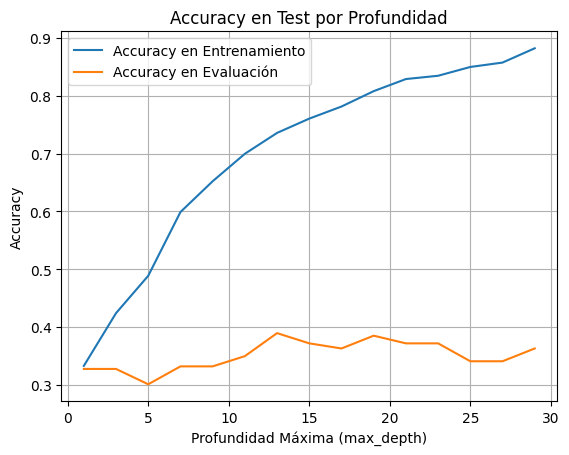

In [291]:
#Profundidad
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

n_jobs = 5  # número de procesos en paralelo
min_depth = 1
max_depth = 30
depth_hop = 2
n_estimators=15 #Base de 15 arboles

# Almacenar resultados
results = []

# Doble ciclo para probar combinaciones
for max_depth_val in range(min_depth, max_depth, depth_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_sinopsis_gen, y_train_gen)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_gen, rf_model.predict(X_train_sinopsis_gen))
        test_acc = accuracy_score(y_test_gen, rf_model.predict(X_test_sinopsis_gen))

        # Almacenar resultados
        results.append({'max_depth': max_depth_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_dfa = pd.DataFrame(results)

# Visualización 1: Accuracy por profundidad para cada número de árboles
results_dfa.set_index("max_depth", inplace=True)
results_dfa["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_dfa["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Profundidad')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Como puede observarse, la profundidad optima del arbol es 3 para evitar el sobreajuste.

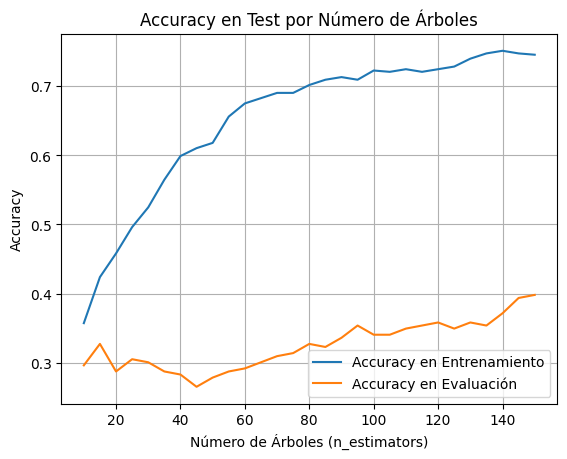

In [292]:
# Número de árboles
min_estimators = 10
max_estimators = 150
estimator_hop = 5
max_depth_val = 3 # paso anterior

# Almacenar resultados
results_estimators = []

# Ciclo para probar diferentes números de árboles
for n_estimators_val in range(min_estimators, max_estimators + 1, estimator_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators_val,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_sinopsis_gen, y_train_gen)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_gen, rf_model.predict(X_train_sinopsis_gen))
        test_acc = accuracy_score(y_test_gen, rf_model.predict(X_test_sinopsis_gen))

        # Almacenar resultados
        results_estimators.append({'n_estimators': n_estimators_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_estimators_dfb = pd.DataFrame(results_estimators)

# Visualización: Accuracy por número de árboles
results_estimators_dfb.set_index("n_estimators", inplace=True)
results_estimators_dfb["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_estimators_dfb["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Número de Árboles')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

De acuerdo con lo anterior, el número óptimo de árboles donde evitamos el sobreajuste es entre 10 y 20 árboles. Aunque la precición es baja. Vamos a considerar 15 árboles para entrenar el modelo. Así pues, los parámetros óptimos para el modelo son los siguientes:

  - max_depth=3
  - n_estimators=15

In [293]:
#Entrenamiento del modelo.
RF_model = RandomForestClassifier(random_state=42,max_depth=3,n_estimators=15,n_jobs=n_jobs,class_weight='balanced')
RF_model.fit(X_train_sinopsis_gen, y_train_gen)

#Prediccion
y_pred = RF_model.predict(X_test_sinopsis_gen)
cm_gen_sinopsis_rf=confusion_matrix(y_test_gen, y_pred)

ags_rf=cm_gen_sinopsis_rf[0,0]
bgs_rf=cm_gen_sinopsis_rf[0,1]
cgs_rf=cm_gen_sinopsis_rf[1,0]
dgs_rf=cm_gen_sinopsis_rf[1,1]

TP_gen_sin_rf=dgs_rf/(cgs_rf+dgs_rf)
FP_gen_sin_rf=bgs_rf/(ags_rf+bgs_rf)
TN_gen_sin_rf=ags_rf/(ags_rf+bgs_rf)
FN_gen_sin_rf=cgs_rf/(cgs_rf+dgs_rf)

accuracy_gen_sin_rf = (ags_rf+dgs_rf)/(ags_rf+bgs_rf+cgs_rf+dgs_rf)
error_gen_sin_rf = 1-accuracy_gen_sin_rf
precision_gen_sin_rf=TP_gen_sin_rf/(TP_gen_sin_rf+FP_gen_sin_rf)
recall_gen_sin_rf=TP_gen_sin_rf/(TP_gen_sin_rf+FN_gen_sin_rf)
F_gen_sin_rf=2*(precision_gen_sin_rf*recall_gen_sin_rf)/(precision_gen_sin_rf+recall_gen_sin_rf)

print("Accuracy_gen_sin RF: ", round(accuracy_gen_sin_rf,4))
print("Error_gen_sin RF: ", round(error_gen_sin_rf,4))
print("Precision_gen_sin RF: ", round(precision_gen_sin_rf,4))
print("Recall_gen_sin RF: ", round(recall_gen_sin_rf,4))
print("F-meassure_gen_sin RF: ", round(F_gen_sin_rf,4))

Accuracy_gen_sin RF:  0.5904
Error_gen_sin RF:  0.4096
Precision_gen_sin RF:  0.7803
Recall_gen_sin RF:  0.1579
F-meassure_gen_sin RF:  0.2626


#### Decada

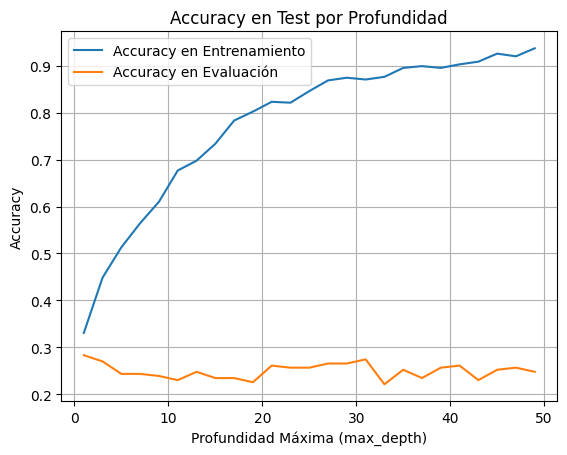

In [294]:
#Profundidad
n_jobs = 5  # número de procesos en paralelo
min_depth = 1
max_depth = 50
depth_hop = 2
n_estimators=15 #Base de 15 arboles

# Almacenar resultados
results = []

# Doble ciclo para probar combinaciones
for max_depth_val in range(min_depth, max_depth, depth_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_sinopsis_dec, y_train_dec)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_dec, rf_model.predict(X_train_sinopsis_dec))
        test_acc = accuracy_score(y_test_dec, rf_model.predict(X_test_sinopsis_dec))

        # Almacenar resultados
        results.append({'max_depth': max_depth_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_dfc = pd.DataFrame(results)

# Visualización 1: Accuracy por profundidad para cada número de árboles
results_dfc.set_index("max_depth", inplace=True)
results_dfc["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_dfc["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Profundidad')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Podemos ver que la profundidad óptima del arbol sin caer en sobreajuste esta entre 1 y 5. Sin embargo, con esta profundidad el accuracy es bajo. Por ello, consideramos una profundidad de 2

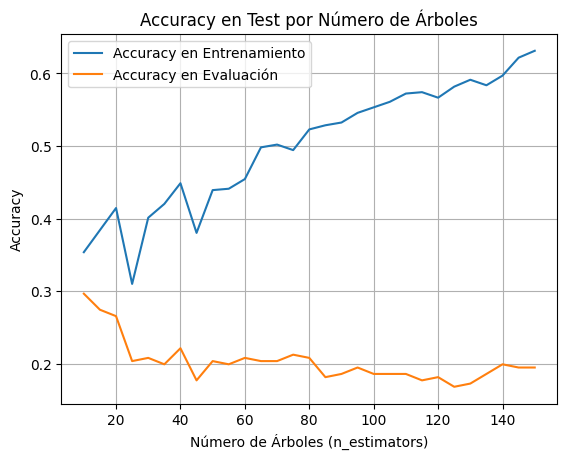

In [295]:
# Número de árboles
min_estimators = 10
max_estimators = 150
estimator_hop = 5

# Almacenar resultados
results_estimators = []

# Ciclo para probar diferentes números de árboles
for n_estimators_val in range(min_estimators, max_estimators + 1, estimator_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=2,
            n_estimators=n_estimators_val,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_sinopsis_dec, y_train_dec)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_dec, rf_model.predict(X_train_sinopsis_dec))
        test_acc = accuracy_score(y_test_dec, rf_model.predict(X_test_sinopsis_dec))

        # Almacenar resultados
        results_estimators.append({'n_estimators': n_estimators_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_estimators_dfd = pd.DataFrame(results_estimators)

# Visualización: Accuracy por número de árboles
results_estimators_dfd.set_index("n_estimators", inplace=True)
results_estimators_dfd["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_estimators_dfd["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Número de Árboles')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Como podemos observar, el número de arboles con mayor precisión sin caer en sobreajuste es de 10. Aunque la precisión es baja. Por tanto, los parámetros óptimos para estimar este modelo son:

  - max_depth=2
  - n_estimators=10

In [296]:
#Entrenanamiento del modelo.
RF_model_dec = RandomForestClassifier(random_state=42,max_depth=2,n_estimators=10,n_jobs=n_jobs,class_weight='balanced')
RF_model_dec.fit(X_train_sinopsis_dec, y_train_dec)

#Prediccion
y_pred = RF_model_dec.predict(X_test_sinopsis_dec)
cm_dec_sinopsis_rf=confusion_matrix(y_test_dec, y_pred)

ads_rf=cm_dec_sinopsis_rf[0,0]
bds_rf=cm_dec_sinopsis_rf[0,1]
cds_rf=cm_dec_sinopsis_rf[1,0]
dds_rf=cm_dec_sinopsis_rf[1,1]

TP_dec_sin_rf=dds_rf/(cds_rf+dds_rf)
FP_dec_sin_rf=bds_rf/(ads_rf+bds_rf)
TN_dec_sin_rf=ads_rf/(ads_rf+bds_rf)
FN_dec_sin_rf=cds_rf/(cds_rf+dds_rf)

accuracy_dec_sin_rf = (ads_rf+dds_rf)/(ads_rf+bds_rf+cds_rf+dds_rf)
error_dec_sin_rf = 1-accuracy_dec_sin_rf
precision_dec_sin_rf=TP_dec_sin_rf/(TP_dec_sin_rf+FP_dec_sin_rf)
recall_dec_sin_rf=TP_dec_sin_rf/(TP_dec_sin_rf+FN_dec_sin_rf)
F_dec_sin_rf=2*(precision_dec_sin_rf*recall_dec_sin_rf)/(precision_dec_sin_rf+recall_dec_sin_rf)

print("Accuracy_dec_sin RF: ", round(accuracy_dec_sin_rf,4))
print("Error_dec_sin RF: ", round(error_dec_sin_rf,4))
print("Precision_dec_sin RF: ", round(precision_dec_sin_rf,4))
print("Recall_dec_sin RF: ", round(recall_dec_sin_rf,4))
print("F-meassure_dec_sin RF: ", round(F_dec_sin_rf,4))

Accuracy_dec_sin RF:  0.2222
Error_dec_sin RF:  0.7778
Precision_dec_sin RF:  0.2105
Recall_dec_sin RF:  0.2
F-meassure_dec_sin RF:  0.2051


### Sinopsis+Titulo

#### Género

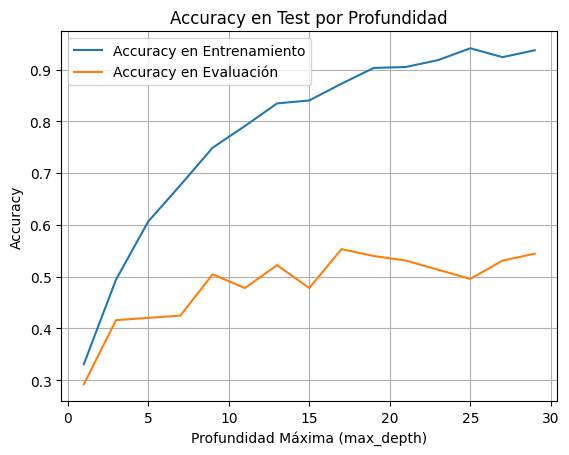

In [297]:
#Profundidad
n_jobs = 5  # número de procesos en paralelo
min_depth = 1
max_depth = 30
depth_hop = 2
n_estimators=15 #Base de 15 arboles

# Almacenar resultados
results = []

# Doble ciclo para probar combinaciones
for max_depth_val in range(min_depth, max_depth, depth_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_comb_gen, y_train_gen)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_gen, rf_model.predict(X_train_comb_gen))
        test_acc = accuracy_score(y_test_gen, rf_model.predict(X_test_comb_gen))

        # Almacenar resultados
        results.append({'max_depth': max_depth_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_dfe = pd.DataFrame(results)

# Visualización 1: Accuracy por profundidad para cada número de árboles
results_dfe.set_index("max_depth", inplace=True)
results_dfe["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_dfe["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Profundidad')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Vemos que la profundidad apropiada sin caer en sobreajuste es de 3.

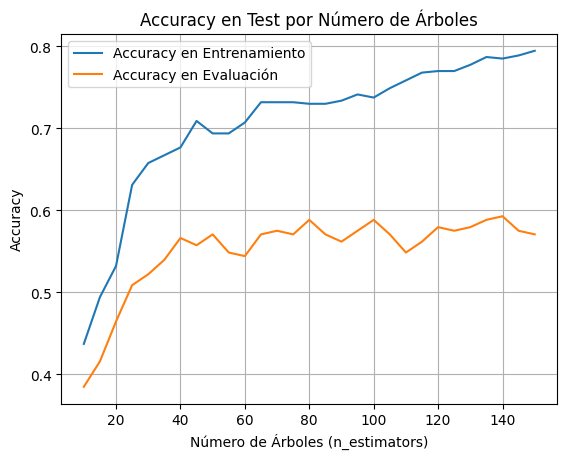

In [298]:
# Número de árboles
min_estimators = 10
max_estimators = 150
estimator_hop = 5
max_depth_val = 3 # paso anterior

# Almacenar resultados
results_estimators = []

# Ciclo para probar diferentes números de árboles
for n_estimators_val in range(min_estimators, max_estimators + 1, estimator_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators_val,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_comb_gen, y_train_gen)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_gen, rf_model.predict(X_train_comb_gen))
        test_acc = accuracy_score(y_test_gen, rf_model.predict(X_test_comb_gen))

        # Almacenar resultados
        results_estimators.append({'n_estimators': n_estimators_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_estimators_df = pd.DataFrame(results_estimators)

# Visualización: Accuracy por número de árboles
results_estimators_df.set_index("n_estimators", inplace=True)
results_estimators_df["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_estimators_df["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Número de Árboles')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Observamos que el número de àrboles con mayor Accuracy sin caer en sobreajuste es de 22. Por tanto, los parámetros óptimos son:

  - max_depth=3
  - n_estimators=22

In [299]:
#Entrenamiento del modelo.
RF_model = RandomForestClassifier(random_state=42,max_depth=3,n_estimators=22,n_jobs=n_jobs,class_weight='balanced')
RF_model.fit(X_train_comb_gen, y_train_gen)

#Prediccion
y_pred = RF_model.predict(X_test_comb_gen)
cm_gen_c_rf=confusion_matrix(y_test_gen, y_pred)

agc_rf=cm_gen_c_rf[0,0]
bgc_rf=cm_gen_c_rf[0,1]
cgc_rf=cm_gen_c_rf[1,0]
dgc_rf=cm_gen_c_rf[1,1]

TP_gen_c_rf=dgc_rf/(cgc_rf+dgc_rf)
FP_gen_c_rf=bgc_rf/(agc_rf+bgc_rf)
TN_gen_c_rf=agc_rf/(agc_rf+bgc_rf)
FN_gen_c_rf=cgc_rf/(cgc_rf+dgc_rf)

accuracy_gen_c_rf = (agc_rf+dgc_rf)/(agc_rf+bgc_rf+cgc_rf+dgc_rf)
error_gen_c_rf = 1-accuracy_gen_c_rf
precision_gen_c_rf=TP_gen_c_rf/(TP_gen_c_rf+FP_gen_c_rf)
recall_gen_c_rf=TP_gen_c_rf/(TP_gen_c_rf+FN_gen_c_rf)
F_gen_c_rf=2*(precision_gen_c_rf*recall_gen_c_rf)/(precision_gen_c_rf+recall_gen_c_rf)

print("Accuracy_gen_c RF: ", round(accuracy_gen_c_rf,4))
print("Error_gen_c RF: ", round(error_gen_c_rf,4))
print("Precision_gen_c RF: ", round(precision_gen_c_rf,4))
print("Recall_gen_c RF: ", round(recall_gen_c_rf,4))
print("F-meassure_gen_c RF: ", round(F_gen_c_rf,4))

Accuracy_gen_c RF:  0.8108
Error_gen_c RF:  0.1892
Precision_gen_c RF:  0.8793
Recall_gen_c RF:  0.6774
F-meassure_gen_c RF:  0.7653


#### Decada

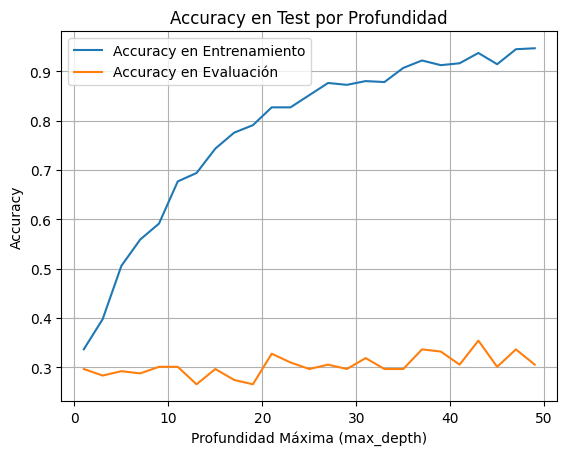

In [300]:
#Profundidad
n_jobs = 5  # número de procesos en paralelo
min_depth = 1
max_depth = 50
depth_hop = 2
n_estimators=15 #Base de 15 arboles

# Almacenar resultados
results = []

# Doble ciclo para probar combinaciones
for max_depth_val in range(min_depth, max_depth, depth_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=max_depth_val,
            n_estimators=n_estimators,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_comb_dec, y_train_dec)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_dec, rf_model.predict(X_train_comb_dec))
        test_acc = accuracy_score(y_test_dec, rf_model.predict(X_test_comb_dec))

        # Almacenar resultados
        results.append({'max_depth': max_depth_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_dfg = pd.DataFrame(results)

# Visualización 1: Accuracy por profundidad para cada número de árboles
results_dfg.set_index("max_depth", inplace=True)
results_dfg["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_dfg["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Profundidad')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

observamos que, en este caso, la profundidad optima sin caer en sobreajuste es de 1

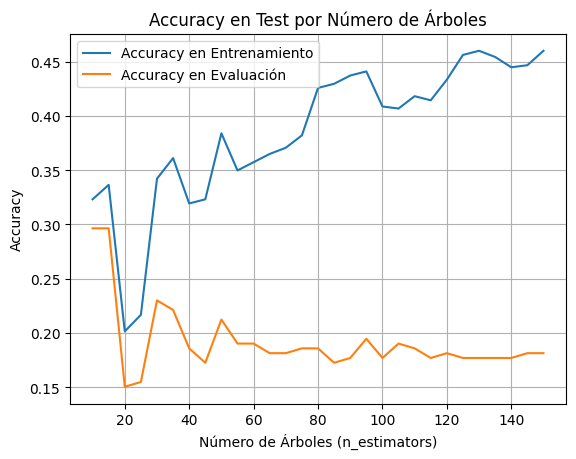

In [301]:
# Número de árboles
min_estimators = 10
max_estimators = 150
estimator_hop = 5

# Almacenar resultados
results_estimators = []

# Ciclo para probar diferentes números de árboles
for n_estimators_val in range(min_estimators, max_estimators + 1, estimator_hop):
        # Crear y entrenar el modelo
        rf_model = RandomForestClassifier(
            random_state=42,
            max_depth=1,
            n_estimators=n_estimators_val,
            n_jobs=n_jobs,
            class_weight='balanced'
        )
        rf_model.fit(X_train_comb_dec, y_train_dec)

        # Calcular accuracy para train y test
        train_acc = accuracy_score(y_train_dec, rf_model.predict(X_train_comb_dec))
        test_acc = accuracy_score(y_test_dec, rf_model.predict(X_test_comb_dec))

        # Almacenar resultados
        results_estimators.append({'n_estimators': n_estimators_val,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Convertir resultados a DataFrame
results_estimators_dfh = pd.DataFrame(results_estimators)

# Visualización: Accuracy por número de árboles
results_estimators_dfh.set_index("n_estimators", inplace=True)
results_estimators_dfh["train_accuracy"].plot(label="Accuracy en Entrenamiento")
results_estimators_dfh["test_accuracy"].plot(label="Accuracy en Evaluación")

plt.title('Accuracy en Test por Número de Árboles')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

El númnero de árboles con mayor Accuracy sin caer en sobreajuste es de 15. Por tanto, los parámetros óptimos son:

  - max_depth=1
  - n_estimators=15

In [302]:
#Entrenanamiento del modelo.
RF_model_dec = RandomForestClassifier(random_state=42,max_depth=1,n_estimators=15,n_jobs=n_jobs,class_weight='balanced')
RF_model_dec.fit(X_train_comb_dec, y_train_dec)

#Prediccion
y_pred = RF_model_dec.predict(X_test_comb_dec)
cm_dec_c_rf=confusion_matrix(y_test_dec, y_pred)

adc_rf=cm_dec_c_rf[0,0]
bdc_rf=cm_dec_c_rf[0,1]
cdc_rf=cm_dec_c_rf[1,0]
ddc_rf=cm_dec_c_rf[1,1]

TP_dec_c_rf=ddc_rf/(cdc_rf+ddc_rf)
FP_dec_c_rf=bdc_rf/(adc_rf+bdc_rf)
TN_dec_c_rf=adc_rf/(adc_rf+bdc_rf)
FN_dec_c_rf=cdc_rf/(cdc_rf+ddc_rf)

accuracy_dec_c_rf = (adc_rf+ddc_rf)/(adc_rf+bdc_rf+cdc_rf+ddc_rf)
error_dec_c_rf = 1-accuracy_dec_c_rf
precision_dec_c_rf=TP_dec_c_rf/(TP_dec_c_rf+FP_dec_c_rf)
recall_dec_c_rf=TP_dec_c_rf/(TP_dec_c_rf+FN_dec_c_rf)
F_dec_c_rf=2*(precision_dec_c_rf*recall_dec_c_rf)/(precision_dec_c_rf+recall_dec_c_rf)

print("Accuracy_dec_c RF: ", round(accuracy_dec_c_rf,4))
print("Error_dec_c RF: ", round(error_dec_c_rf,4))
print("Precision_dec_c RF: ", round(precision_dec_c_rf,4))
print("Recall_dec_c RF: ", round(recall_dec_c_rf,4))
print("F-meassure_dec_c RF: ", round(F_dec_c_rf,4))

Accuracy_dec_c RF:  0.5
Error_dec_c RF:  0.5
Precision_dec_c RF:  0.4
Recall_dec_c RF:  0.6667
F-meassure_dec_c RF:  0.5


## Modelo de regresión Arbol Decisión

Para implementar los árboles de decision, al igual que antes, es necesario encontrar la profundidad optima del arbol (max_depth)

### Sinopsis

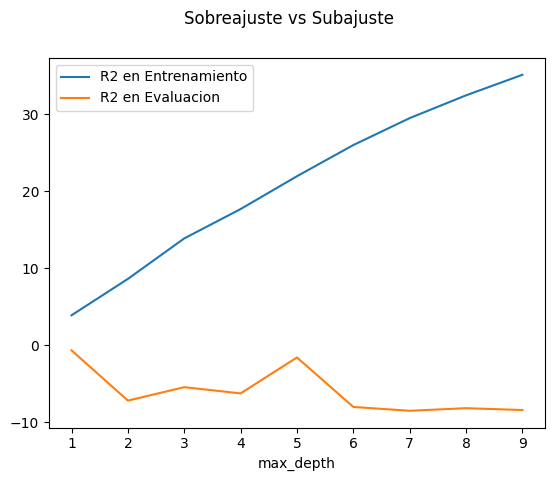

In [303]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=42, max_depth=maxdepth)
  tree_model.fit(X_train_sinopsis_punt, y_train_punt)

  pred_train = tree_model.predict(X_train_sinopsis_punt)
  pred_test = tree_model.predict(X_test_sinopsis_punt)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train_sinopsis_punt, y_train_punt))
  score_test_list.append(100.0*tree_model.score(X_test_sinopsis_punt, y_test_punt))
  mse_train_list.append(mean_squared_error(y_train_punt, pred_train))
  mse_test_list.append(mean_squared_error(y_test_punt, pred_test))

dfi = pd.DataFrame({"max_depth":md_list,
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })
#Visualizacion
dfi.set_index("max_depth", inplace=True)
dfi["score_train"].plot(label="R2 en Entrenamiento")
dfi["score_test"].plot(label="R2 en Evaluacion")
plt.suptitle("Sobreajuste vs Subajuste")
plt.legend()
plt.show();

Vemos que la profundidad del arbol con menor sobreajuste es 1. Asimismo, observamos que el modelo explica muy poco en los datos de prueba. Ello puede deberse a que la sinopsis de las peliculas no contiene información relevante para predecir la calificación de dicha pelicula.

In [304]:
import numpy as np

#Entrenanamiento del modelo.
tree_model = DecisionTreeRegressor(random_state=42, max_depth=1)
tree_model.fit(X_train_sinopsis_punt, y_train_punt)

#Prediccion
pred_train = tree_model.predict(X_train_sinopsis_punt)
pred_test = tree_model.predict(X_test_sinopsis_punt)

mae_sin = mean_absolute_error(y_test_punt, pred_test)
mse_sin = mean_squared_error(y_test_punt, pred_test)
rmse_sin = np.sqrt(mse_sin)
r2_sin = r2_score(y_test_punt, pred_test)

# Imprimir las métricas de evaluación
print("Mean Absolute Error (MAE): {:.3f}".format(mae_sin))
print("Mean Squared Error (MSE): {:.3f}".format(mse_sin))
print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse_sin))
print("R-squared (R2): {:.3f}".format(r2_sin))



Mean Absolute Error (MAE): 0.829
Mean Squared Error (MSE): 1.099
Root Mean Squared Error (RMSE): 1.048
R-squared (R2): -0.007


### Sinopsis+Titulo

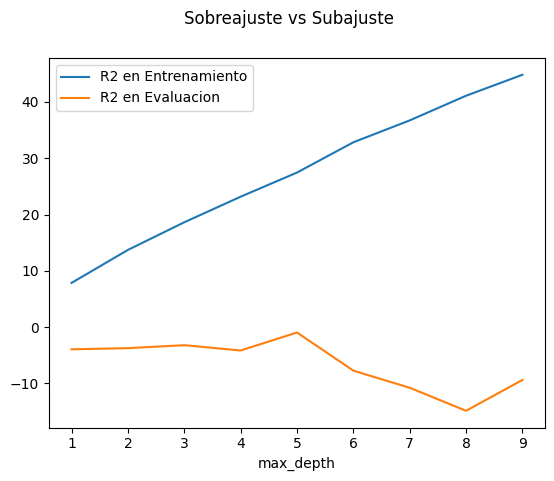

In [305]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=42, max_depth=maxdepth)
  tree_model.fit(X_train_comb_punt, y_train_punt)

  pred_train = tree_model.predict(X_train_comb_punt)
  pred_test = tree_model.predict(X_test_comb_punt)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train_comb_punt, y_train_punt))
  score_test_list.append(100.0*tree_model.score(X_test_comb_punt, y_test_punt))
  mse_train_list.append(mean_squared_error(y_train_punt, pred_train))
  mse_test_list.append(mean_squared_error(y_test_punt, pred_test))

dfj = pd.DataFrame({"max_depth":md_list,
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })
#Visualizacion
dfj.set_index("max_depth", inplace=True)
dfj["score_train"].plot(label="R2 en Entrenamiento")
dfj["score_test"].plot(label="R2 en Evaluacion")
plt.suptitle("Sobreajuste vs Subajuste")
plt.legend()
plt.show();

Vemos que, el comportamiento es el mismo que con los datos solo de Sinopsis. La profundidad con menor sobreajuste es 1.

In [306]:
#Entrenanamiento del modelo.
tree_model = DecisionTreeRegressor(random_state=42, max_depth=1)
tree_model.fit(X_train_comb_punt, y_train_punt)

#Prediccion
pred_train = tree_model.predict(X_train_comb_punt)
pred_test = tree_model.predict(X_test_comb_punt)

mae_c = mean_absolute_error(y_test_punt, pred_test)
mse_c = mean_squared_error(y_test_punt, pred_test)
rmse_c = np.sqrt(mse_sin)
r2_c = r2_score(y_test_punt, pred_test)

# Imprimir las métricas de evaluación
print("Mean Absolute Error (MAE): {:.3f}".format(mae_c))
print("Mean Squared Error (MSE): {:.3f}".format(mse_c))
print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse_c))
print("R-squared (R2): {:.3f}".format(r2_c))


Mean Absolute Error (MAE): 0.844
Mean Squared Error (MSE): 1.135
Root Mean Squared Error (RMSE): 1.048
R-squared (R2): -0.039


## Modelo de regresión Gradient Boosting



#### Sinopsis

  - Optimización de parámetros

Para el este modelo, vamos a utilizar como modelo base (weak learner) a los árboles de decisión. En tal sentido, los hiperparámetros importantes son nuevamente la profundidad de los árboles, el número de árboles y la **tasa de aprendizaje**.

**Profundidad de los árboles**

Una de las virtudes del modelo Gradient Boosting es que los weak learners son sencillos y su fortaleza radica en ir mejorando con cada iteración a partir del primer modelo o arbol entrenado. Por esta razón, vamos a utilizar árboles sencillos de profundidad 1.

**Número de árboles y Tasa de aprendizaje**

Dado que el número de árboles está vinculado con la tasa de aprendizaje (un mayor número de árboles puede requerir una tasa de apendizaje más baja para controlar la convergencia y evitar el sobreajuste, mientras que un menor número de árboles puede requerir una tasa de aprendizaje más alta para acelerar la convergencia y evitar subajuste) debemos encontrar la combinación óptima del número de árboles y la tasa de aprendizaje. Para ello, a continuación probamos el rendimiento del modelo (R2) para distintas combinaciones del número de árboles y tasas de aprendizaje.

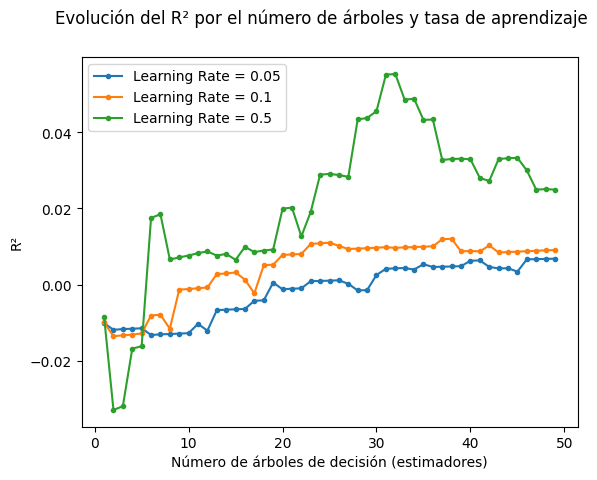

In [307]:
from sklearn.ensemble import GradientBoostingRegressor
max_depth = 1 #weak learner más simple
min = 1
max = 50

for learning_rate in [0.05, 0.1, 0.5]:
  R2_list = []
  for n_estimators in range (min, max):
    gb_model = GradientBoostingRegressor(random_state=42, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    gb_model.fit(X_train_sinopsis_punt, y_train_punt)
    R2_list.append(gb_model.score(X_test_sinopsis_punt, y_test_punt))

  plt.plot(range(min,max), R2_list, marker='.', linestyle='-', label="Learning Rate = " + str(learning_rate))

plt.suptitle("Evolución del R² por el número de árboles y tasa de aprendizaje")
plt.xlabel('Número de árboles de decisión (estimadores)')
plt.ylabel("R²")
plt.legend()
plt.show()

Podemos observar que la precisión más elevada se alcanza en cerca de 32 arboles y con una tasa de aprendizaje de 0.5. Asimismo, observamos que la R2 es baja, incluso llega a ser negativa. Esto sugiere que la sinopsis no contiene información relevante que permite estimar la puntuación de la película. Incluir a los actores o al director podría aportar mayor poder predictivo al modelo.
Por lo tanto, los parámetros óptimos del modelo son:

  - max_depth=1
  - n_estimators=32
  - learning_rate=0.5

In [308]:
#Modelo con parámetros optimizados

GB_model_optimo = GradientBoostingRegressor(random_state=42, n_estimators=32, max_depth=1, learning_rate=0.5)
GB_model_optimo.fit(X_train_sinopsis_punt, y_train_punt)

pred_train = GB_model_optimo.predict(X_train_sinopsis_punt)
pred_test = GB_model_optimo.predict(X_test_sinopsis_punt)


mae_GB = mean_absolute_error(y_test_punt, pred_test)
mse_GB = mean_squared_error(y_test_punt, pred_test)
rmse_GB = np.sqrt(mse_GB)
r2_GB = r2_score(y_test_punt, pred_test)

Precision_train_GB=100.0*GB_model_optimo.score(X_train_sinopsis_punt, y_train_punt)
Precision_test_GB=100.0*GB_model_optimo.score(X_test_sinopsis_punt, y_test_punt)

# Imprimir las métricas de evaluación del modelo Gradient Boosting
print("Mean Absolute Error (MAE): {:.3f}".format(mae_GB))
print("Mean Squared Error (MSE): {:.3f}".format(mse_GB))
print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse_GB))
print("R-squared (R2): {:.3f}".format(r2_GB))
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(Precision_train_GB))
print("Precisión sobre los datos de test: {:.2f}".format(Precision_test_GB))


Mean Absolute Error (MAE): 0.800
Mean Squared Error (MSE): 1.031
Root Mean Squared Error (RMSE): 1.016
R-squared (R2): 0.055
Precisión sobre los datos de entrenamiento: 41.81
Precisión sobre los datos de test: 5.53


#### Sinopsis+Titulo

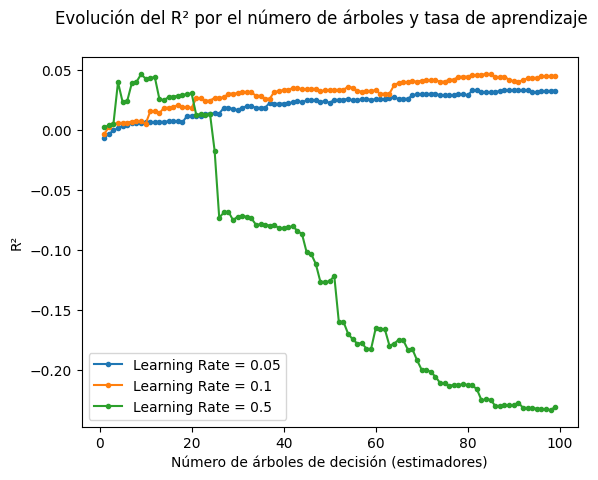

In [309]:
#Numero de árboles y tasa de aprendizaje
max_depth = 1 #weak learner más simple
min = 1
max = 100

for learning_rate in [0.05, 0.1, 0.5]:
  R2_list = []
  for n_estimators in range (min, max):
    gb_model = GradientBoostingRegressor(random_state=42, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    gb_model.fit(X_train_comb_punt, y_train_punt)
    R2_list.append(gb_model.score(X_test_comb_punt, y_test_punt))

  plt.plot(range(min,max), R2_list, marker='.', linestyle='-', label="Learning Rate = " + str(learning_rate))

plt.suptitle("Evolución del R² por el número de árboles y tasa de aprendizaje")
plt.xlabel('Número de árboles de decisión (estimadores)')
plt.ylabel("R²")
plt.legend()
plt.show()

Podemos observar que la precisión crece muy lentamente en el número de árboles para las tasas de 0,05 y 0,1. Podemos ver que 60 arboles con una tasa de 0,1 ya es apropiado. Asimismo, observamos que la R2 es baja, incluso llega a ser negativa para tasas de 0,5. Esto sugiere que ni la sinopsis ni el titulo contienen información relevante que permite estimar la puntuación de la película. Incluir a los actores o al director podría aportar mayor poder predictivo al modelo.
Por lo tanto, los parámetros óptimos del modelo son:

  - max_depth=1
  - n_estimators=60
  - learning_rate=0.1

In [310]:
#Modelo con parámetros optimizados

GB_model_optimo = GradientBoostingRegressor(random_state=42, n_estimators=60, max_depth=1, learning_rate=0.1)
GB_model_optimo.fit(X_train_comb_punt, y_train_punt)

pred_train = GB_model_optimo.predict(X_train_comb_punt)
pred_test = GB_model_optimo.predict(X_test_comb_punt)


mae_GB_c = mean_absolute_error(y_test_punt, pred_test)
mse_GB_c = mean_squared_error(y_test_punt, pred_test)
rmse_GB_c = np.sqrt(mse_GB_c)
r2_GB_c = r2_score(y_test_punt, pred_test)

# Imprimir las métricas de evaluación del modelo Gradient Boosting
print("Mean Absolute Error (MAE): {:.3f}".format(mae_GB_c))
print("Mean Squared Error (MSE): {:.3f}".format(mse_GB_c))
print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse_GB_c))
print("R-squared (R2): {:.3f}".format(r2_GB_c))

Mean Absolute Error (MAE): 0.814
Mean Squared Error (MSE): 1.056
Root Mean Squared Error (RMSE): 1.028
R-squared (R2): 0.033


# **Visualización**

  - Comentar los resultados obtenidos.
  - ¿Qué variable fue más fácil de predecir? ¿El título o la sinopsis aporta más información?
  - ¿Cuántas películas se necesitan por clase para que el modelo generalice bien?

A continuación mostramos los resultados de los distintos modelos.

In [311]:
#Comparación de los modelos de clasificacion
from IPython.display import display, HTML
display(HTML("<h2>Comparación de Métricas para Predicción de Género</h2>"))
#Género
Metricas_Gen = pd.DataFrame({
    'Métrica': ['Accuracy', 'Error', 'Precision', 'Recall', 'F-Score)'],
    'KNN (S)': [
        f"{accuracy_gen_sin:.3f}",
        f"{error_gen_sin:.3f}",
        f"{precision_gen_sin:.3f}",
        f"{recall_gen_sin:.3f}",
        f"{F_gen_sin:.2f}"
    ],
    'Random Forest (S)': [
        f"{accuracy_dec_sin_rf:.3f}",
        f"{error_gen_sin_rf:.3f}",
        f"{precision_dec_sin_rf:.3f}",
        f"{recall_gen_sin_rf:.3f}",
        f"{F_gen_sin_rf:.2f}"
    ],
    'KNN (S+T)': [
        f"{accuracy_gen_c:.3f}",
        f"{error_gen_c:.3f}",
        f"{precision_gen_c:.3f}",
        f"{recall_gen_c:.3f}",
        f"{F_gen_c:.2f}"
    ],
    'Random Forest (S+T)': [
        f"{accuracy_dec_c_rf:.3f}",
        f"{error_gen_c_rf:.3f}",
        f"{precision_dec_c_rf:.3f}",
        f"{recall_gen_c_rf:.3f}",
        f"{F_gen_c_rf:.2f}"
    ]
})
# Tabla comparativa
Metricas_Gen = Metricas_Gen.set_index('Métrica')
print(Metricas_Gen)

          KNN (S) Random Forest (S) KNN (S+T) Random Forest (S+T)
Métrica                                                          
Accuracy    0.789             0.222     0.850               0.500
Error       0.211             0.410     0.150               0.189
Precision   0.791             0.211     0.851               0.400
Recall      0.787             0.158     0.848               0.677
F-Score)     0.79              0.26      0.85                0.77


Como puede observarse, el modelo que mejor predice el género de las películas (en términos de Accuracy) es el modelo KNN. Asimismo, notamos que el título de la pelicula si aporta información para predecir, ya que el Accuracy pasó de 78,9% a 85% cuando se considera el titulo (S+T)

In [312]:
#Tabla Metricas_decada
display(HTML("<h2>Comparación de Métricas para Predicción de Década</h2>"))
Metricas_Dec = pd.DataFrame({
    'Métrica': ['Accuracy', 'Error', 'Precision', 'Recall', 'F-Score)'],
    'KNN (S)': [
        f"{accuracy_dec_sin:.3f}",
        f"{error_dec_sin:.3f}",
        f"{precision_dec_sin:.3f}",
        f"{recall_dec_sin:.3f}",
        f"{F_dec_sin:.2f}"
    ],
    'Random Forest (S)': [
        f"{accuracy_dec_sin_rf:.3f}",
        f"{error_dec_sin_rf:.3f}",
        f"{precision_dec_sin_rf:.3f}",
        f"{recall_dec_sin_rf:.3f}",
        f"{F_dec_sin_rf:.2f}"
    ],
    'KNN (S+T)': [
        f"{accuracy_dec_c:.3f}",
        f"{error_dec_c:.3f}",
        f"{precision_dec_c:.3f}",
        f"{recall_dec_c:.3f}",
        f"{F_dec_c:.2f}"
    ],
    'Random Forest (S+T)': [
        f"{accuracy_dec_c_rf:.3f}",
        f"{error_dec_c_rf:.3f}",
        f"{precision_dec_c_rf:.3f}",
        f"{recall_dec_c_rf:.3f}",
        f"{F_dec_c_rf:.2f}"
    ]
})
# Tabla comparativa
Metricas_Dec = Metricas_Dec.set_index('Métrica')
print(Metricas_Dec)

          KNN (S) Random Forest (S) KNN (S+T) Random Forest (S+T)
Métrica                                                          
Accuracy    0.560             0.222     0.667               0.500
Error       0.440             0.778     0.333               0.500
Precision   0.516             0.211     0.645               0.400
Recall      0.333             0.200     0.364               0.667
F-Score)     0.41              0.21      0.47                0.50


Para el caso de la variable década, el modelo que mejor ajusta es nuevamente el KNN. Aunque la predicción no es tan precisa. Si se considera únicamente la información contenida en la sinopsis, el Accuracy es de 56%. Si se incluye el título, el Acurracy mejora hasta 66,7%, lo que indica que el titulo contiene información que si aporta en predecir la década de estreno de la película.

In [313]:
#Comparación de los modelos de regresión
#Puntuación
display(HTML("<h2>Comparación de Métricas para Predicción de Puntuación</h2>"))

Metricas_Reg = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'RMSE', 'R²'],
    'D Tree (S)': [
        f"{mae_sin:.3f}",
        f"{mse_sin:.3f}",
        f"{rmse_sin:.3f}",
        f"{r2_sin:.3f}"
    ],
    'Gradient B (S)': [
        f"{mae_GB:.3f}",
        f"{mse_GB:.3f}",
        f"{rmse_GB:.3f}",
        f"{r2_GB:.3f}"
    ],
    'D Tree (S+T)': [
        f"{mae_c:.3f}",
        f"{mse_c:.3f}",
        f"{rmse_c:.3f}",
        f"{r2_c:.3f}"
    ],
    'Gradient B (S+T)': [
        f"{mae_GB:.3f}",
        f"{mse_GB:.3f}",
        f"{rmse_GB:.3f}",
        f"{r2_GB:.3f}"
    ]
})

# Tabla comparativa
Metricas_Reg = Metricas_Reg.set_index('Métrica')
print(Metricas_Reg)


        D Tree (S) Gradient B (S) D Tree (S+T) Gradient B (S+T)
Métrica                                                        
MAE          0.829          0.800        0.844            0.800
MSE          1.099          1.031        1.135            1.031
RMSE         1.048          1.016        1.048            1.016
R²          -0.007          0.055       -0.039            0.055


Comentar los resultados obtenidos.
¿Qué variable fue más fácil de predecir? ¿El título o la sinopsis aporta más información?
¿Cuántas películas se necesitan por clase para que el modelo generalice bien?

Para el caso de la variable continua "Puntuación", se observa que la predicción es muy pobre si la medimos en términos de la R2. Esto ocurre con el modelo de arbol de decisión y con el modelo de Gradient Boosting. Esto puede deberse a que la información contenida en la sinopsis y el título no contiene información relevante para predecir que tanto se valora la pelicula. Esto tambien sugiere que la puntuación de la película esta afectada por otras variables que no captura la sinopsis ni el titulo. Ejemplos de estas variables pueden ser los actores que actuan en la pelicula, el director o el presupuesto destinado a la producción de la película. Por estas razones, la variable más difícil de predecir es precisamente esta, la puntuación.

Asimismo, para mejorar la predicción en los modelos de clasificacion del género, es recomendable incluir información adicional sobre el més de estreno (algunas películas, como las de terror, suelen tener fechas de estreno cercanas al dia de brujas), actores o director.